#### Goal
Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so. The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it). The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue. This challenge is significantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges.

**We want to:**

- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate

#### Data Discription
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
# Set display format

pd.set_option('display.max_columns',10)
pd.set_option('display.width',350)

In [17]:
df = pd.read_csv('conversion_project.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


- country : user country based on the IP address (category data)
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source; (category data) 1. Ads: came to the site by clicking on an advertisement. 2. Seo: came to the site by clicking on search results. 3. Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. 

The company goal is to **increase conversion rate: # conversions / total sessions**

### 1. Exploratory Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [19]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [20]:
df.nunique()

country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64

**Quick Analysis**
- Most users are young, there are outliers in "age" feature though.
- Average conversion rate is 3.23%, which is around industrial standard.

#### Concersion Rate vs. Country
- Germany has the highest conversion rate
- China has lots of users visiting website, however, its conversion rate is extremely low

In [21]:
df[['country','converted']].groupby('country').mean().sort_values(by='converted', ascending=False)

,converted
country,
Germany,0.062500
UK,0.052632
US,0.037801
China,0.001332


Text(0.5, 1.0, 'Mean Conversion Rate of countries')

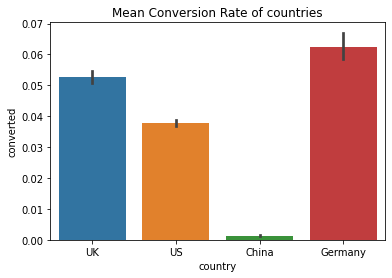

In [22]:
sns.barplot(x='country',y='converted',data=df)
# Bar plot uses "mean" by default
plt.title('Mean Conversion Rate of countries')

Text(0.5, 1.0, 'Country vs. Converted')

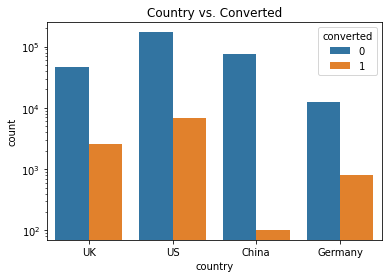

In [23]:
sns.countplot(x='country', hue='converted', data=df)
plt.yscale('log') # change y-axis unit to "log" 
plt.title('Country vs. Converted')

#### Concersion Rate vs. Source

In [24]:
df.groupby('source')['converted'].mean().sort_values(ascending=False) 
# For dataframe, "by" is needed, as last example. For series is not.

source
Ads       0.034483
Seo       0.032895
Direct    0.028169
Name: converted, dtype: float64

Text(0.5, 1.0, 'Source vs. Converted')

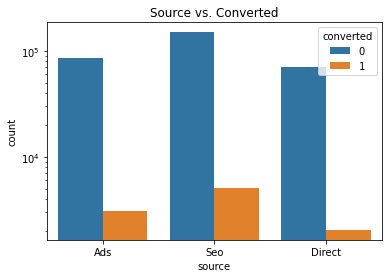

In [25]:
sns.countplot(x='source', hue='converted', data=df)
plt.yscale('log') # change y-axis unit to "log" 
plt.title('Source vs. Converted')

#### Concersion Rate vs. Age

In [26]:
# Check "age" outliers, and remove them
df[df['age']>80]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [27]:
df = df[df['age']<80]

C:\Users\28149\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\28149\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age Distribution vs. Converted')

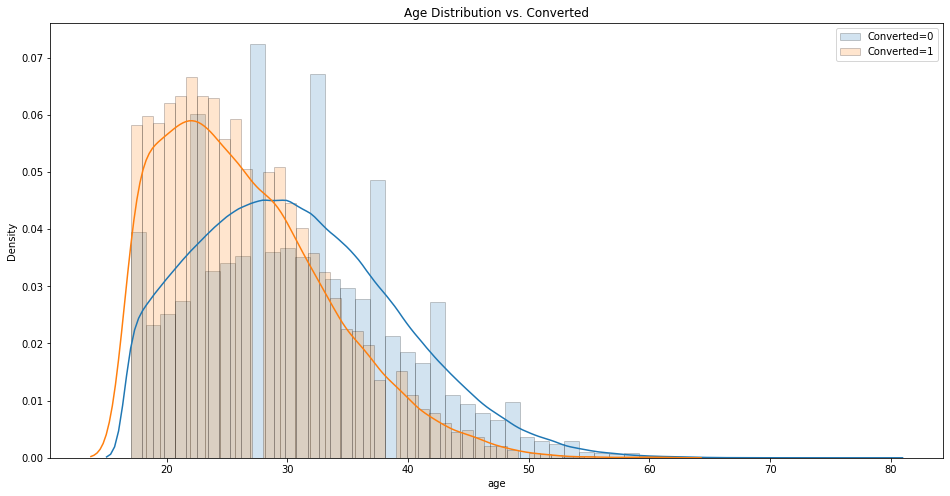

In [28]:
hist = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
sns.distplot(df[df['converted']==0]['age'], label='Converted=0', hist_kws=hist)
sns.distplot(df[df['converted']==1]['age'], label='Converted=1', hist_kws=hist)
plt.legend()
plt.title('Age Distribution vs. Converted')


In [29]:
mean_age = df.groupby('age')['converted'].mean().reset_index()
mean_age.head()

,age,converted
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


Text(0.5, 1.0, 'Conversion Rate vs. Age')

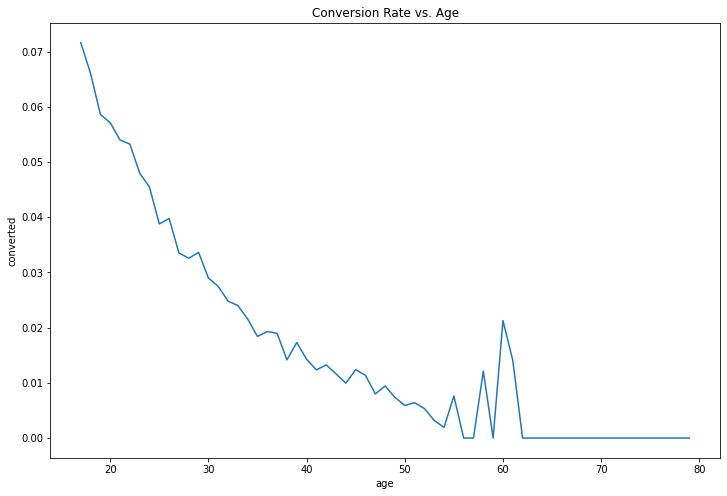

In [30]:
plt.figure(figsize=(12,8))
sns.lineplot(x='age',y='converted', data=mean_age)
plt.title('Conversion Rate vs. Age')

**Quick Analysis**
- converted users are distributed around 20s, and non-converted users are around 30s
- As age increases, conversion rate decreases

#### Conversion Rate vs. Number of visited pages
- There is a positive correlation between conversion rate and number of visited page. The more users visit website page, the higher conversion rate is. 
- However, it doesn't necessarily mean that number of visit increase conversion rate. Instead, the positive correlation is probably because that when users want to buy something, they tend to visit the web more.

C:\Users\28149\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\28149\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of total_pages_visited')

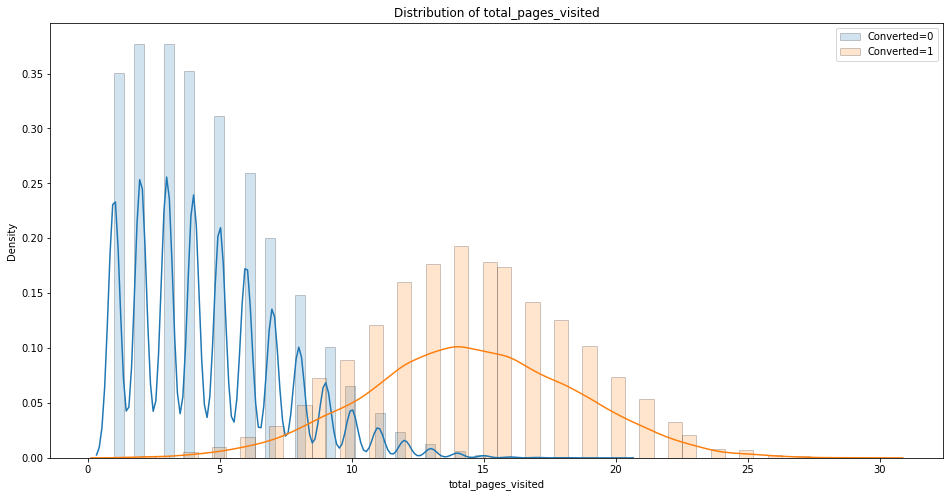

In [31]:
hist = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
sns.distplot(df[df['converted']==0]['total_pages_visited'], label='Converted=0', hist_kws=hist)
sns.distplot(df[df['converted']==1]['total_pages_visited'], label='Converted=1', hist_kws=hist)
plt.legend()
plt.title('Distribution of total_pages_visited')


Text(0.5, 1.0, 'Conversion Rate vs. Number of visited pages')

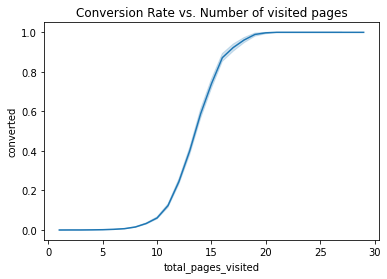

In [32]:
sns.lineplot(x='total_pages_visited',y='converted',data=df)
# "mean" by default
plt.title('Conversion Rate vs. Number of visited pages')

Text(0.5, 1.0, 'Correlation Heatmap')

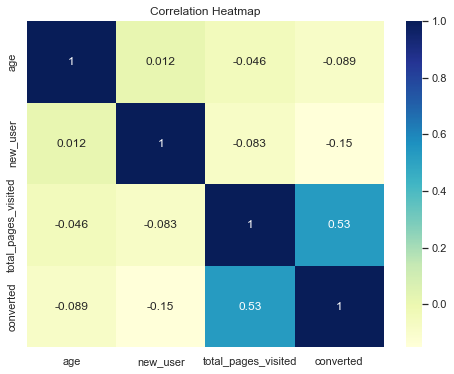

In [33]:
# Correlation Heatmap

sns.set(rc = {'figure.figsize':(8,6)})
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation Heatmap')

- The heatmap above indicates the strong positive correlation between conversion rate and number of visited page

#### Conversion Rate vs. New user
- The conversion rate is much higher among Non new users compared to new users

Text(0.5, 1.0, 'New user vs. Converted')

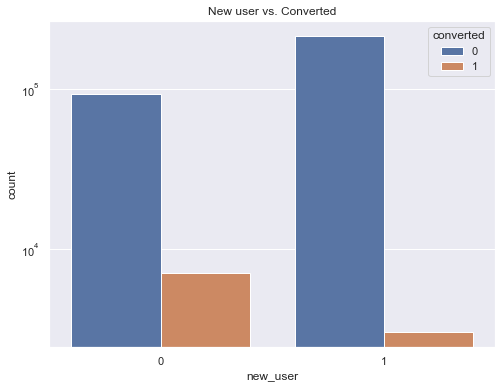

In [158]:
sns.countplot(x='new_user', hue='converted', data=df)
plt.yscale('log') 
plt.title('New user vs. Converted')

Text(0.5, 1.0, 'Average conversion rate: New user or not')

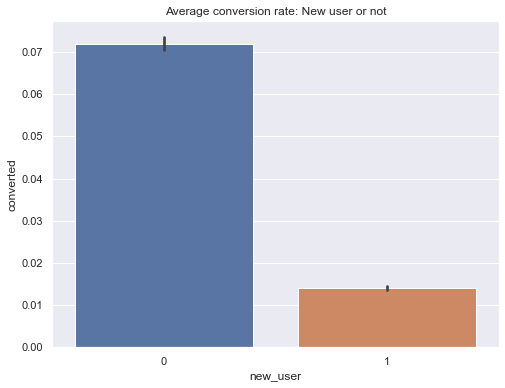

In [159]:
sns.barplot(x='new_user', y='converted', data=df)
plt.title('Average conversion rate: New user or not')

### 2. Data Preprocessing
- Checked missing value
- Removed outliers (Have done above)
- Transformed categorical variables to dummy

In [34]:
len(df)

316198

In [35]:
# Check missing values (No missing value)
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [36]:
# Get dummy
df1 = pd.get_dummies(df, drop_first=True)
df1.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


### 3. ML models
- Logistic Regression
- Random Forest

#### Training/Test Split

In [112]:
from sklearn.model_selection import train_test_split

X = df1.drop(['converted'], axis=1)
y = df1['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [113]:
# Check training/test set
print(X_train.shape, y_train.shape,'\n', X_test.shape, y_test.shape)

(221338, 8) (221338,) 
 (94860, 8) (94860,)


#### Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()

In [115]:
# Fit model

logistic_regression.fit(X_train,y_train)

C:\Users\28149\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [116]:
# Prediction

pred_lr = logistic_regression.predict(X_test)
pred_lr = pd.DataFrame(pred_lr)

In [117]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm_lr = pd.DataFrame(
    confusion_matrix(y_test, pred_lr),
    columns=['Predicted Non-Converted', 'Predicted Converted'],
    index=['True Non-Converted', 'True Converted']
)
cm_lr

,Predicted Non-Converted,Predicted Converted
True Non-Converted,91486,342
True Converted,913,2119


In [118]:
# Performance metrics

from sklearn.metrics import classification_report
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91828
           1       0.86      0.70      0.77      3032

    accuracy                           0.99     94860
   macro avg       0.93      0.85      0.88     94860
weighted avg       0.99      0.99      0.99     94860



In [119]:
# Predict LR probability

proba_lr = logistic_regression.predict_proba(X_test)
proba_lr = pd.DataFrame(proba_lr, columns=logistic_regression.classes_)
proba_lr.head()

,0,1
0,0.999707,0.000293
1,0.999954,0.000046
2,0.999173,0.000827
3,0.991238,0.008762
4,0.988317,0.011683


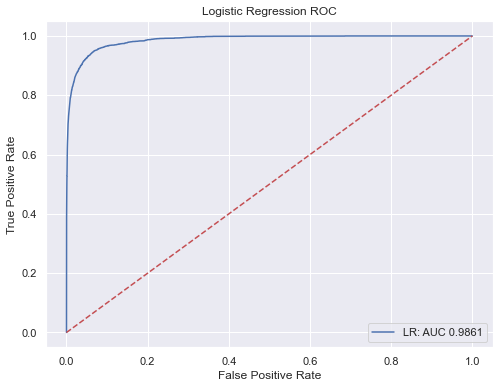

In [120]:
# ROC

from sklearn.metrics import roc_curve, auc
fp, tp, thresholds = roc_curve(y_test, proba_lr[1])
roc_auc = auc(fp, tp)

plt.plot(fp, tp, 'b', label='%s: AUC %0.4f'% ('LR',roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.title('Logistic Regression ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [121]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=10, random_state=1)

In [122]:
# Fit model

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, oob_score=True, random_state=1)

In [123]:
# Prediction

pred_rf = rf.predict(X_test)
pred_rf = pd.DataFrame(pred_rf)

In [124]:
# Confusion Matrix

cm_rf = pd.DataFrame(
    confusion_matrix(y_test, pred_rf),
    columns=['Predicted Non-Converted', 'Predicted Converted'],
    index=['True Non-Converted', 'True Converted']
)
cm_rf

,Predicted Non-Converted,Predicted Converted
True Non-Converted,91448,380
True Converted,939,2093


In [125]:
# Performance metrics

print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91828
           1       0.85      0.69      0.76      3032

    accuracy                           0.99     94860
   macro avg       0.92      0.84      0.88     94860
weighted avg       0.99      0.99      0.99     94860



In [126]:
# Predict LR probability

proba_rf = rf.predict_proba(X_test)
proba_rf = pd.DataFrame(proba_rf, columns=rf.classes_)
proba_rf.head()

,0,1
0,0.989628,0.010372
1,0.999429,0.000571
2,0.996919,0.003081
3,0.993746,0.006254
4,0.984307,0.015693


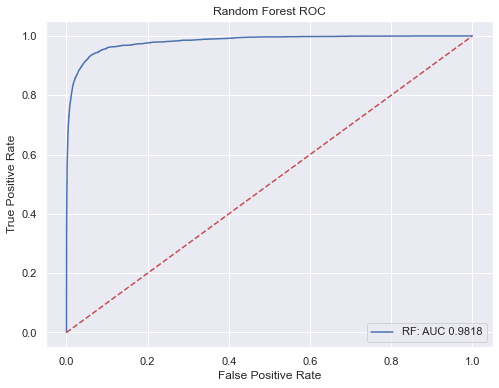

In [128]:
# ROC

from sklearn.metrics import roc_curve, auc
fp, tp, thresholds = roc_curve(y_test, proba_rf[1])
roc_auc = auc(fp, tp)

plt.plot(fp, tp, 'b', label='%s: AUC %0.4f'% ('RF',roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.title('Random Forest ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [129]:
# Feature Importance

feature_importance = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': rf.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance

,Feature,Importance
2,total_pages_visited,0.867966
0,age,0.053964
1,new_user,0.041579
4,country_UK,0.011632
5,country_US,0.011505
3,country_Germany,0.008320
7,source_Seo,0.002529
6,source_Direct,0.002504


Text(0.5, 1.0, 'Feature Importance Plot')

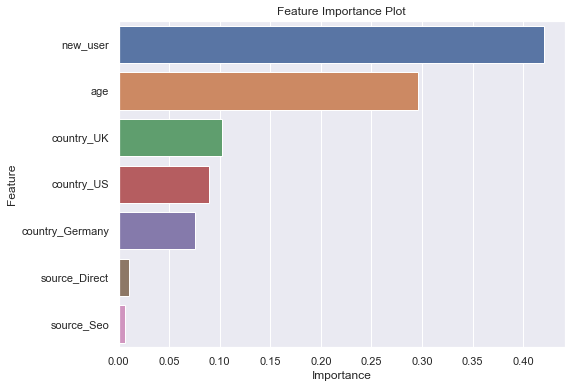

In [154]:
# Importance Plot

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance Plot')

- Here, the number of page visited is the most important feature. However, as memtioned earlier, it's probably the case that users visiting is caused by the action of purchase, instead of causing a purchase.
- Because of this, I'll remove "total_pages_visited" and model it again.

In [131]:
# Remove total_pages_visited
X_novisit = X.drop(['total_pages_visited'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_novisit,y, test_size=0.3, random_state=2)

# Fit model again
rf = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, oob_score=True, random_state=1)

In [148]:
# Prediction

pred_rf = rf.predict(X_test)
pred_rf = pd.DataFrame(pred_rf)

In [153]:
# Unbalanced class issue
# len(y_test[y_test==1])/len(y_test)

In [138]:
# Feature Importance

feature_importance = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': rf.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance

,Feature,Importance
1,new_user,0.420418
0,age,0.296325
3,country_UK,0.102331
4,country_US,0.089859
2,country_Germany,0.075230
5,source_Direct,0.009820
6,source_Seo,0.006016


Text(0.5, 1.0, 'Feature Importance Plot (Remove total_pages_visited)')

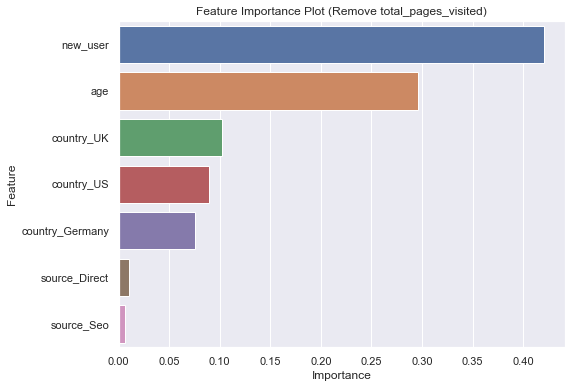

In [156]:
# Importance Plot

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance Plot (Remove total_pages_visited)')

- After removing total_pages_visited, now **new_user** and **age** become the most important features.

### 4. Summary

- This website is working very well among **young** users, attracting lots of young users to purchase, which indicates that the current marketing strategy/website UI design are quite successful for young users.
- **German** users have the highest conversion rate, however, the number of visited users in Germany is the lowest. Therefore, future marketing should target to German users and it's a good idea to increase the website exposure in Germany
- New users are less likely to be converted, compared to **non new users**. Thus, keeping the users stayed is the key, and we can do this by emailing users every once a while to inform them the latest news or discount, and maintaining a good relationship with users.
- There must be some issues on the **Chinese** version of the website, since the number of visited users are so large, but so few of them actually converted. The issues might be bad translation, local culture difference, or payment issues. Given how large the Chinese users group is, there'a a great potential in Chinese market.
- **Older user** visit quite a bit but rarely purchase. We might need to do some user surveys and figure out what the reason is/what old users preference is/...